# 2D BCSD Crack example (2DP1)

Instead of just one collocation point per element like in the case of the 2DP0 kernel, the 2DP1 kernel has 2 collocation points.

The displacement boundary conditions are specified as follows,
$$
D(x) = {2 (1-\nu) \tau_F \over \pi G} \{ x \ln \big| {x\sqrt{c^2 - a^2} + a\sqrt{c^2 - x^2} \over x\sqrt{c^2 - a^2} - a\sqrt{c^2 - x^2}} \big| - a \ln \big| {\sqrt{c^2 - a^2} + \sqrt{c^2 - x^2} \over \sqrt{c^2 - a^2} - \sqrt{c^2 - x^2}} \big| \}
$$

We construct an augmented collocation matrix to place two collocation points per element.

The analytical traction solution for the BCSD crack is given as seen in Weertman (1996), 
$$
t(x) =
    \begin{cases}
        \sigma_A & \text{if } x \leq |a|\\
        \sigma_A-\tau_F & \text{if } |c| \geq x > |a|
    \end{cases}
$$

In [1]:
import numpy as np
import sys
import os
np.set_printoptions(precision=5, suppress=True)
import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors

%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [3.5, 3.5]
plt.rcParams['font.size'] = 12
#plt.rcParams['text.usetex']=True
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1
plt.rcParams["savefig.dpi"] = 100
#plt.rcParams["text.latex.preamble"] =r'\usepackage{amsmath}'+ r'\usepackage{amssymb}' + r'\usepackage{accents}'+ r'\usepackage{bm}'+ r'\boldmath'+ r'\renewcommand{\v}[1]{\boldsymbol{{#1}}}'+ r'\DeclareRobustCommand{\sot}[1]{\boldsymbol{{#1}}}'

norm1 = lambda a : np.linalg.norm(a, axis=1)
norm = lambda a : np.linalg.norm(a)

from bigwham4py import BEMatrix 

In [2]:
G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)
alpha = 1 - nu

tau_F = 1.0
sigma_A = (2 * tau_F)/3

ct_pressure = sigma_A
pz_pressure = sigma_A - tau_F

pre_fac = - 2 * ((alpha*tau_F) / (np.pi*G))

a = 1.0 
c = 2.0

In [3]:
#plastic zone formula
#pz_fac_2 = 1 + 2*pz_fac*np.sin((np.pi*sigma_A)/(4*tau_F))**2
#c_2 = a*pz_fac_2

# Mesh
nelts = 100
coor1D = np.linspace(-c, c, nelts + 1)
coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)

# H-matrix parameters
max_leaf_size = 100
eta = 3.
eps_aca = 1.e-4

# Hmatrix
kernel = "2DS1-H"
elas_prop = np.array([E, nu])
hmat = BEMatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca,n_openMP_threads=8)

# get augmented collocation points
col_pts_aug = np.zeros((conn.shape[0] * 2, conn.shape[1]))
count = 0
col_pts_aug[count, :] = coor[0, :]
count += 1
for i in range(1, coor.shape[0] -  1):
    col_pts_aug[count, :] = coor[i, :]
    count += 1
    col_pts_aug[count, :] = coor[i, :]
    count += 1
col_pts_aug[count, :] = coor[i+1, :]

NUM OF AVAILABLE OMP THREADS: 16
BigWham using 8 OpenMP threads
 Now setting things for kernel ... 2DS1-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  8e-06
 binary cluster tree depth =1
 Number of blocks =4
 Number of full blocks =4
 Number of low rank blocks =0
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 4 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.074258
Compression ratio - 1
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 1, eps_aca = 0.0001, eta = 3
Hierarchical matrix  construction time = :  0.074285
BigWham constructed Hmat of size (200 x 2) X (200 x 2)
--------------------


In [4]:
dd = np.zeros(col_pts_aug.shape)

pzl2 = np.sqrt(c**2 - a**2) 
x_pzl2 = col_pts_aug[:, 0]*pzl2
ctzl2 = np.sqrt(c**2 - col_pts_aug[:, 0]**2)
a_ctzl2 = a*ctzl2

dd[:, 1] = pre_fac * (col_pts_aug[:, 0]*np.log(abs((x_pzl2 + a_ctzl2)/(x_pzl2 - a_ctzl2))) - a*np.log(abs((pzl2 + ctzl2)/(pzl2 - ctzl2))))

#due to nan value at derivative discontinuity at x=+/-a for dd, the following substitutions are made
dd[:, 1][int(len(dd)/4)-1] = 0.6618431437
dd[:, 1][int(len(dd)/4)] = 0.6618431437
dd[:, 1][int(3*len(dd)/4)-1] = 0.6618431437
dd[:, 1][int(3*len(dd)/4)] = 0.6618431437

#runtime warnings below are to be ignored

/var/folders/0z/p784_8y56_g9mjz5rvfb8vg00000gn/T/ipykernel_37552/3660186116.py:8: RuntimeWarning: divide by zero encountered in divide
  dd[:, 1] = pre_fac * (col_pts_aug[:, 0]*np.log(abs((x_pzl2 + a_ctzl2)/(x_pzl2 - a_ctzl2))) - a*np.log(abs((pzl2 + ctzl2)/(pzl2 - ctzl2))))
/var/folders/0z/p784_8y56_g9mjz5rvfb8vg00000gn/T/ipykernel_37552/3660186116.py:8: RuntimeWarning: divide by zero encountered in log
  dd[:, 1] = pre_fac * (col_pts_aug[:, 0]*np.log(abs((x_pzl2 + a_ctzl2)/(x_pzl2 - a_ctzl2))) - a*np.log(abs((pzl2 + ctzl2)/(pzl2 - ctzl2))))
/var/folders/0z/p784_8y56_g9mjz5rvfb8vg00000gn/T/ipykernel_37552/3660186116.py:8: RuntimeWarning: invalid value encountered in subtract
  dd[:, 1] = pre_fac * (col_pts_aug[:, 0]*np.log(abs((x_pzl2 + a_ctzl2)/(x_pzl2 - a_ctzl2))) - a*np.log(abs((pzl2 + ctzl2)/(pzl2 - ctzl2))))


In [5]:
# calculate tractions
t = hmat.matvec(dd.flatten())

t_anal = np.zeros(col_pts_aug.shape)
t_anal[:, 1] = ct_pressure

for i in range(len(t_anal)):
    if abs(col_pts_aug[i][0])>=a:
        t_anal[i][1] = pz_pressure

Text(0, 0.5, 'Displacement')

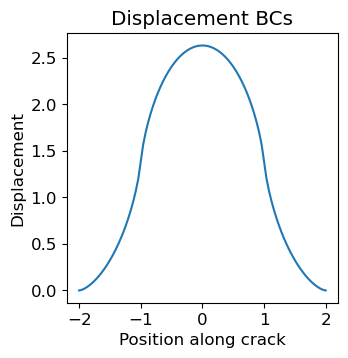

In [6]:
dd_norm = dd/(-a*pre_fac)
plt.plot(col_pts_aug[:, 0], dd_norm[:, 1])
plt.title("Displacement BCs")
plt.xlabel("Position along crack")
plt.ylabel("Displacement")

Text(0, 0.5, 'Traction')

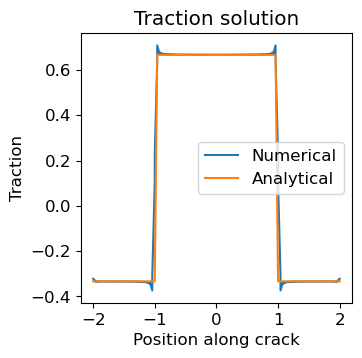

In [7]:
plt.plot(col_pts_aug[:, 0], t.reshape(-1, 2)[:, 1])
plt.plot(col_pts_aug[:, 0], t_anal[:, 1])
plt.legend(["Numerical", "Analytical"])
plt.title("Traction solution")
plt.xlabel("Position along crack")
plt.ylabel("Traction")

In [ ]:
nelts_array = [10**i for i in range(6)]
rel_err_array = []

plt.figure(figsize=(10,6))

for nelts in nelts_array:
    # Mesh
    coor1D = np.linspace(-c, c, nelts + 1)
    coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
    conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)

    # H-matrix parameters
    max_leaf_size = 100
    eta = 3.
    eps_aca = 1.e-4

    # Hmatrix
    kernel = "2DS1-H"
    elas_prop = np.array([E, nu])
    hmat = BEMatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca,n_openMP_threads=8)

    col_pts = np.zeros((conn.shape[0] * 2, conn.shape[1]))
    count = 0
    col_pts[count, :] = coor[0, :]
    count += 1
    for i in range(1, coor.shape[0] -  1):
        col_pts[count, :] = coor[i, :]
        count += 1
        col_pts[count, :] = coor[i, :]
        count += 1
    #col_pts[count, :] = coor[i+1, :]

    dd = np.zeros(col_pts.shape)

    pzl2 = np.sqrt(c**2 - a**2)
    x_pzl2 = col_pts[:, 0]*pzl2
    ctzl2 = np.sqrt(c**2 - col_pts[:, 0]**2)
    a_ctzl2 = a*ctzl2

    dd[:, 1] = pre_fac * (col_pts[:, 0]*np.log(abs((x_pzl2 + a_ctzl2)/(x_pzl2 - a_ctzl2))) - a*np.log(abs((pzl2 + ctzl2)/(pzl2 - ctzl2))))

    #if nelts > 20:
    dd[:, 1][int(len(dd)/4)-1] = 0.6618431437
    dd[:, 1][int(len(dd)/4)] = 0.6618431437
    dd[:, 1][int(3*len(dd)/4)-1] = 0.6618431437
    dd[:, 1][int(3*len(dd)/4)] = 0.6618431437

    # calculate tractions
    t = hmat.matvec(dd.flatten())

    t_anal = np.zeros(col_pts.shape)
    t_anal[:, 1] = ct_pressure
    for i in range(len(t_anal)):
        if abs(col_pts[i][0])>=a:
            t_anal[i][1] = pz_pressure

    rel_err = np.linalg.norm(t - t_anal.flatten()) / t.shape[0]
    print("L2 Rel error {}".format(rel_err))
    rel_err_array.append(rel_err)

    #plt.plot(col_pts[:, 0], t.reshape(-1, 2)[:, 1], label = 'num =' + str(nelts))

    '''
    info
    dd_calc_norm = dd_calc/(a*pre_fac)
    plt.figure()
    #plt.plot(np.linalg.norm(col_pts, axis=1), dd_calc.reshape(-1, 2), ".k")
    plt.plot(col_pts[:, 0], dd_calc_norm.reshape(-1, 2)[:, 1], ".")
    plt.plot(col_pts[:, 0], dd.reshape(-1, 2)[:, 1], ".")
    '''

# plt.plot(col_pts[:, 0], t_anal[:, 1], label='analytical')
# plt.ylim([-3, 3])
# plt.legend()

L2 Rel error 0.18133122376642205NUM OF AVAILABLE OMP THREADS: 16

BigWham using 8 OpenMP threads
 Now setting things for kernel ... 2DS1-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  1e-06
 binary cluster tree depth =0
 Number of blocks =1
 Number of full blocks =1
 Number of low rank blocks =0
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.00025
Compression ratio - 1
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 1, eps_aca = 0.0001, eta = 3
Hierarchical matrix  construction time = :  0.000269
BigWham constructed Hmat of size (2 x 2) X (2 x 2)
-----

/var/folders/0z/p784_8y56_g9mjz5rvfb8vg00000gn/T/ipykernel_37552/536851531.py:40: RuntimeWarning: divide by zero encountered in divide
  dd[:, 1] = pre_fac * (col_pts[:, 0]*np.log(abs((x_pzl2 + a_ctzl2)/(x_pzl2 - a_ctzl2))) - a*np.log(abs((pzl2 + ctzl2)/(pzl2 - ctzl2))))
/var/folders/0z/p784_8y56_g9mjz5rvfb8vg00000gn/T/ipykernel_37552/536851531.py:40: RuntimeWarning: divide by zero encountered in log
  dd[:, 1] = pre_fac * (col_pts[:, 0]*np.log(abs((x_pzl2 + a_ctzl2)/(x_pzl2 - a_ctzl2))) - a*np.log(abs((pzl2 + ctzl2)/(pzl2 - ctzl2))))
/var/folders/0z/p784_8y56_g9mjz5rvfb8vg00000gn/T/ipykernel_37552/536851531.py:40: RuntimeWarning: invalid value encountered in subtract
  dd[:, 1] = pre_fac * (col_pts[:, 0]*np.log(abs((x_pzl2 + a_ctzl2)/(x_pzl2 - a_ctzl2))) - a*np.log(abs((pzl2 + ctzl2)/(pzl2 - ctzl2))))


NUM OF AVAILABLE OMP THREADS: 16
BigWham using 8 OpenMP threads
 Now setting things for kernel ... 2DS1-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  0.00055
 binary cluster tree depth =5
 Number of blocks =250
 Number of full blocks =94
 Number of low rank blocks =156
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 94 
Loop on low rank blocks construction
N low rank blocks 156
dof_dimension: 2
Creation of hmat done in 0.2271
Compression ratio - 0.134702
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 0.134702, eps_aca = 0.0001, eta = 3
Hierarchical matrix  construction time = :  0.227128
BigWham constructed Hmat of size (2000 x 2) X (2000 x 2)
---------

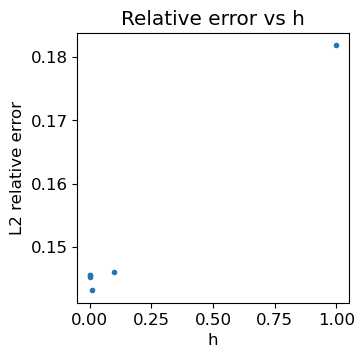

In [ ]:
h_array = [1/nelts for nelts in nelts_array]

plt.figure()
plt.plot(h_array, rel_err_array,'.')
plt.title("Relative error vs h")
plt.xlabel("h")
plt.ylabel("L2 relative error")
#saves fig - remember to remove
#plt.savefig('rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

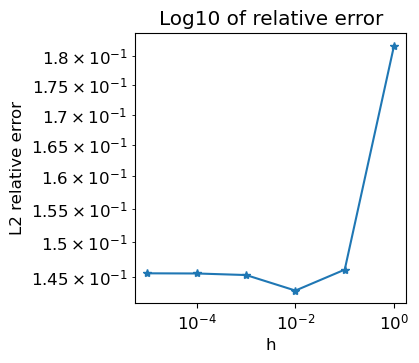

In [ ]:
plt.figure()
plt.plot(h_array, rel_err_array, "*-")
plt.title("Log10 of relative error")
plt.xlabel("h")
plt.ylabel("L2 relative error")
plt.yscale('log')
plt.xscale('log')
#saves fig - remember to remove
#plt.savefig('log_rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
print(h_array)
print(rel_err_array)

log_h = np.log(np.asarray(h_array)[2:])
log_rel_array = np.log(np.asarray(rel_err_array)[2:])

m, c = np.polyfit(log_h, log_rel_array, 1)

print(m)
print(c)

[1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05]
[0.18187500874650694, 0.14603996453007984, 0.14307728627806657, 0.14527021416158054, 0.14549254396558997, 0.14551486186348714]
-0.0022674131889889966
-1.9504325783816199


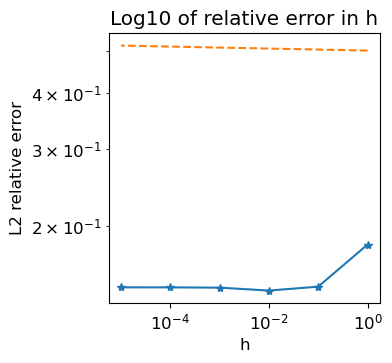

In [ ]:
plt.figure()
plt.plot(h_array, rel_err_array, "*-")
plt.plot(h_array, 0.5*np.array(h_array) ** (m) , "--")
plt.title("Log10 of relative error in h")
plt.xlabel("h")
plt.ylabel("L2 relative error")
plt.yscale('log', base=10)
plt.xscale('log', base=10)
#saves fig - remember to remove
#plt.savefig('log2_rel_err_h.png', dpi=100, bbox_inches='tight')
#plt.show()